In [1]:
import sys         
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.transforms import IdentityTransform
from matplotlib.figure import Figure
from io import BytesIO
from scipy.stats import norm                                                                             
from scipy.stats import energy_distance                                                                  
from sklearn.cluster import KMeans                                                                       
import cv2 as cv                                                                                         
from utils import *   

In [48]:
# Global vars
BRUITS_PARAMS = [                                                                                         
                 (0, 1, 3, 2),                                                                           
                 (1, 1, 1, 5),                                                                           
                 (0, 1, 1, 1),                                                                           
               ]    
IMG_PATH="./images/"
LISTE_IMG=["beee2.bmp","promenade2.bmp","zebre2.bmp"]

CL1, CL2 = (0,255)                                                                                     
DSIZE = 256  

ITER_INDEP = 100
ITER_MC = 20

ERREURS_MAP_MPM = []
ERREURS_MC      = []


In [49]:
# Common functions           
def load_img(img_path, peano=False):   
    img = cv.cvtColor(cv.imread(img_path),cv.COLOR_BGR2GRAY)                                             
    if peano:                                                                                            
        _img = peano_transform_img(img)                                                                  
    else:                                                                                                
        _img = line_transform_img(img)                                                                   
    return _img 
                   
def transform_to_img(Y, dSize=256, peano=False):                                                                     
    if peano:                                                                                            
        img = transform_peano_in_img(Y, dSize)                                                           
    else:                                                                                                
        img = transform_line_in_img(Y, dSize) 
    return img

def get_taux_erreur(X, X_pred):
    erreur = taux_erreur(X, X_pred)                                                                       
    # Si les pixels noirs et blancs sont inversés          
    if erreur > 0.5:                                                                                      
        erreur = 1 - erreur
    return erreur
     

# Modèle des couples indépendants

In [50]:
def init_estim_param_EM_indep(Y, cl1, cl2):                                                              
    kmeans = KMeans(n_clusters=2, random_state=0).fit(Y.reshape(-1,1))   
    
    if abs(kmeans.cluster_centers_[0]) > abs(kmeans.cluster_centers_[1]):
        X = 1-kmeans.labels_
    else: 
        X = kmeans.labels_
        
    X *= cl2                                                                             
                                                                                                         
    pi = (X==cl1).sum()/X.size                                                                           
                                                                                                         
    m1 = np.mean(Y[X==cl1])                                                                              
    sig1 = np.std(Y[X==cl1])                                                                             
                                                                                                         
    m2 = np.mean(Y[X==cl2])                                                                              
    sig2 = np.std(Y[X==cl2])                                                                             
                                                                                                         
    return pi, m1, sig1, m2, sig2              

In [51]:
def estim_param_EM_indep(_iter, Y, pi_0, m1_0, sig1_0, m2_0, sig2_0):                           
                                                                             
    def _p(Y, pi, m1, sig1, m2, sig2):                                                                 
                                                                                                         
        f1 = norm.pdf(Y,m1,sig1)                                                                         
        f2 = norm.pdf(Y,m2,sig2)                                           
                                                                                                         
        __p = np.array([( pi*f1 ) / (pi*f1 + (1-pi)*f2),                                                 
                        ((1-pi)*f2) / (pi*f1 + (1-pi)*f2)                                                
                       ])                                                                                
        return __p                                                                                       
                                                                                
    def next_pi(Y, __p):                                                                                 
        return (1/Y.size) * __p.sum()                                                                    
                                                                                                         
    def next_m(Y, __p):                                                                                  
        return Y.T @ __p / __p.sum()                                                     
                                                                                                         
    def next_sig(Y, __p,_next_m):                                                           
        __Y = (Y - _next_m)**2                                                                           
        return np.sqrt( __Y.T @ __p / __p.sum())                                          
                                                                                                         
    pi    = pi_0                                                                                         
    m1    = m1_0                                                                                 
    sig1  = sig1_0                                                                                       
    m2    = m2_0                                                                                         
    sig2  = sig2_0                                                                                       
                                                                                                         
    for i in range(_iter):                                                                            
        __p = _p(Y, pi, m1, sig1, m2, sig2)                                                              
        pi   = next_pi(Y, __p[0])                                                                        
        m1   = next_m(Y, __p[0])                                                                         
        sig1 = next_sig(Y,__p[0],m1)                                                       
        m2   = next_m(Y, __p[1])                                                                         
        sig2 = next_sig(Y,__p[1],m2)                                                                     
                                                                                                         
    return (pi, m1, sig1, m2, sig2)             

In [52]:
def run_indep_one(X,_iter, bruit,cl1, cl2):                                                                       
    Y = bruit_gauss2(X, cl1, cl2, *bruit)                                                                                                        
    theta0 = init_estim_param_EM_indep(Y, cl1, cl2)                                                      
    theta  = estim_param_EM_indep(_iter,Y, *theta0)                                                      
    X_E = MAP_MPM2(Y,cl1,cl2,theta[0],1-theta[0],*theta[1:])                                             
                                                                                                         
    error = get_taux_erreur(X, X_E)                                                                                      
                                                                                                         
    return X_E, error      

In [53]:
def run_indep_for_one_img(img_path,_iter):
    
    fig,ax = plt.subplots(3,2, figsize=(12,12))
    fig.suptitle("Image originale vs Image segmentée",fontsize=20)
    plt.axis('off')
    X = load_img(img_path) 
    X_pred  = [] 
    erreurs = [] 

    for bruit in BRUITS_PARAMS:
        _X_pred, _erreur = run_indep_one(X,_iter,bruit,CL1,CL2)
        X_pred.append(_X_pred)
        erreurs.append(_erreur)
   
    for i in range(3):
        bruit = BRUITS_PARAMS[i]
        
        ax[i,0].imshow(transform_to_img(X), cmap='gray')
        ax[i,1].imshow(transform_to_img(X_pred[i]), cmap='gray')
        
        ax[i,0].set_xlabel("Image originale")
        ax[i,1].set_xlabel("Image segmentée")
        
        ax[i,0].set_title(''r'$\mu$1 = {}  $\sigma$1 = {} | $\mu$2 = {}  $\sigma$2 = {} '.format(bruit[0],bruit[1],bruit[2],bruit[3]))
        ax[i,1].set_title("Taux d'erreur : {:.2f}".format(erreurs[i]), color='red')
        
        ax[i,0].axis('off')
        ax[i,1].axis('off')
    
    return erreurs

In [54]:
def run_indep_all():
    erreurs = []
    for image in LISTE_IMG:
        erreurs.append(run_indep_for_one_img(IMG_PATH+image,ITER_INDEP))
    return erreurs

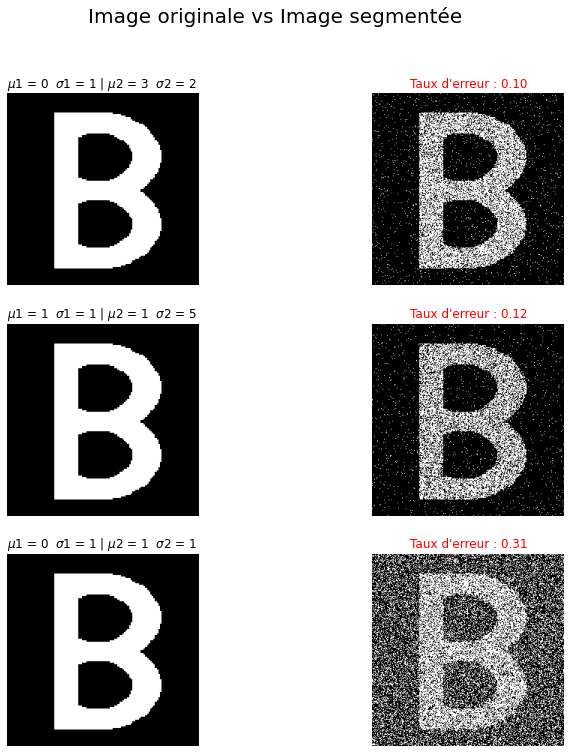

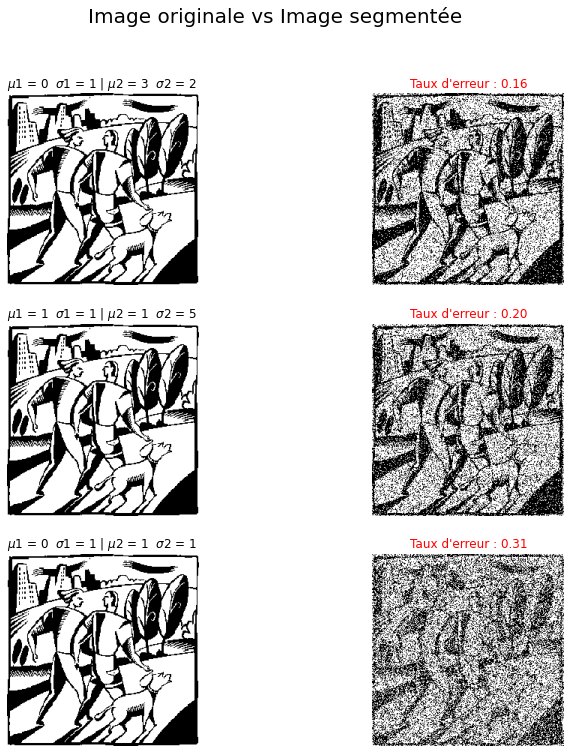

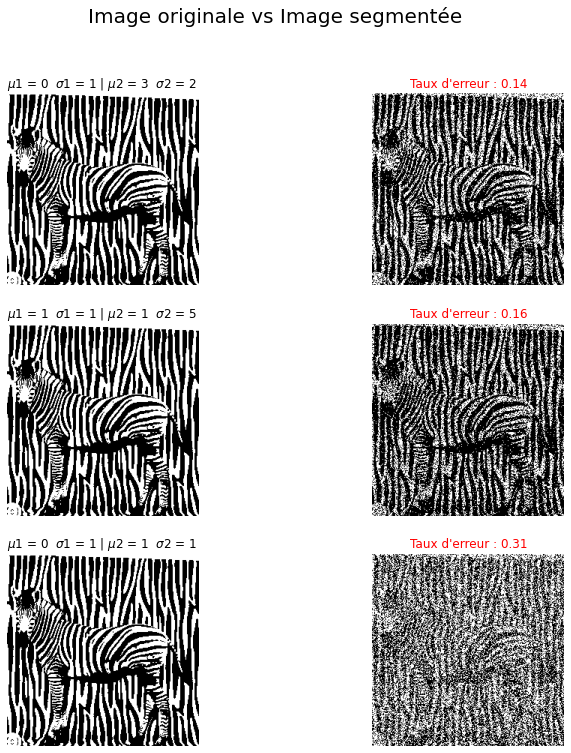

In [55]:
ERREURS_MAP_MPM = run_indep_all()


## Synthèse


In [56]:
pd.DataFrame({'bee2': ERREURS_MAP_MPM[0],
              'promenade2': ERREURS_MAP_MPM[1],
              'zebre2': ERREURS_MAP_MPM[2]},
              index=['bruit_1', 'bruit_2', 'bruit_3'])

,bee2,promenade2,zebre2
bruit_1,0.104736,0.162430,0.135239
bruit_2,0.117722,0.197693,0.161026
bruit_3,0.306961,0.307724,0.308304


# Modèle de chaîne de Markov cachées

In [57]:
def calc_probaprio_mc(X, cl1, cl2):                                                                      
    n = X.size -1                                                                                        
    cl1_n = cl2_n = 0                                                                                    
                                                                                                         
    A = np.zeros((2,2))                                                                                  
    for i in range(n):                                                                                   
        transition = X[i], X[i+1]                                                                        
        if transition   == (cl1, cl1):                                                                   
            A[0,0]+= 1                                                                                   
            cl1_n +=1                                                                                    
        elif transition == (cl2, cl2):                                                                   
            A[1,1]+= 1                                                                                   
            cl2_n +=1                                                                                    
        elif transition == (cl1, cl2):                                                                   
            A[0,1]+= 1                                                                                   
            cl1_n +=1                                                                                    
        elif transition == (cl2, cl1):                                                                   
            A[1,0]+= 1                                                                                   
            cl2_n +=1                                                                                    
                                                                                                         
    A[0] /= cl1_n                                                                                        
    A[1] /= cl2_n                                                                                        
    return  A 

In [58]:
def gauss2(Y, m1, sig1, m2, sig2):                                                                       
    return np.array([norm.pdf(Y, m1, sig1), norm.pdf(Y, m2, sig2)])        

In [59]:
def forward2(Mat_f, A, p10, p20):                                                                        
    n = Mat_f.shape[1]                                                                                   
    alpha = np.zeros(shape=(2,n))                                                                        
                                                                                                         
    alpha[0,0] =  p10 * Mat_f[0,0]                                                                       
    alpha[1,0] =  p20 * Mat_f[1,0]                                                                       
                                                                                                         
    S = alpha[0,0] + alpha[1,0]                                                                          
    alpha[0,0] /= S                                                                                      
    alpha[1,0] /= S                                                                                      
                                                                                                         
    for i in range(1,n):                                                                                 
        alpha[0,i] = ((alpha[0,i-1] * A[0,0]) + (alpha[1, i-1] * A[1,0])) * Mat_f[0,i]                   
        alpha[1,i] = ((alpha[0,i-1] * A[0,1]) + (alpha[1, i-1] * A[1,1])) * Mat_f[1,i]                   
                                                                                                         
        S = alpha[0,i] + alpha[1,i]                                                                      
        alpha[0,i] /= S                                                                                  
        alpha[1,i] /= S                                                                                  
                                                                                                         
    return alpha                                                                                         
                                                                                                         
                                                                                                         
def backward2(Mat_f,A):                                                                                  
                                                                                                         
    n = Mat_f.shape[1]                                                                                   
    beta = np.zeros(shape=(2,n))                                                                         
                                                                                                         
    beta[0,-1] = 1/2                                                                                     
    beta[1,-1] = 1/2                                                                                     
                                                                                                         
    for i in range(n-1,0,-1):                                                                            
        beta[0, i-1] = (beta[0, i] * A[0,0] * Mat_f[0,i]) + (beta[1, i] * A[0,1] * Mat_f[1,i])           
        beta[1, i-1] = (beta[0, i] * A[1,0] * Mat_f[0,i]) + (beta[1, i] * A[1,1] * Mat_f[1,i])           
                                                                                                         
        S = beta[0,i-1] + beta[1,i-1]                                                                    
                                                                                                         
        beta[0,i-1] /= S                                                                                 
        beta[1,i-1] /= S                                                                                 
                                                                                                         
                                                                                                         
    return beta                                                     

In [60]:
def MPM_chaines2(Mat_f, cl1, cl2, A, p10, p20):                                                          
    alpha = forward2(Mat_f, A, p10, p20)                                                                 
    beta  = backward2(Mat_f,A)                                                                           
                                                                                                         
    ksi = alpha * beta                                                                                   
    ksi = ksi / ksi.sum(axis=0)      
    
    return np.where(ksi[0] > ksi[1], cl1, cl2)          

In [61]:
def init_estim_param_EM_mc(Y, cl1, cl2):                                                                 
    kmeans = KMeans(n_clusters=2, random_state=0).fit(Y.reshape(-1,1))                                      

    X = kmeans.labels_
    X *= cl2                                                                                              
    A = calc_probaprio_mc(X, cl1, cl2)                                                                   
                                                                                                         
    p1 = (X==cl1).sum()/X.size                                                                           
    p2 = 1 - p1                                                                                          
                                                                                                         
    m1 = np.mean(Y[X==cl1])                                                                              
    sig1 = np.std(Y[X==cl1])                                                                             
                                                                                                         
    m2 = np.mean(Y[X==cl2])                                                                              
    sig2 = np.std(Y[X==cl2])                                                                             
                                                                                                         
    return A, p1, p2, m1, sig1**2, m2, sig2**2                                                                                                     

In [62]:
def estim_param_EM_mc(_iter, Y, A_0,  p1_0, p2_0, m1_0, sig1_0, m2_0, sig2_0):                           
                                                                                                         
                                                                                                         
    def _ksi(alpha, beta):                                                                               
        ksi =  alpha * beta                                                                               
        ksi /= ksi.sum(axis=0)                                                                      
        return ksi                                                                                       
                                                                                                         
                                                                                                         
    def _psi(Mat_f, A, alpha, beta):                                                                     
                                                                                                         
        psi_0_0 = alpha[0,:-1] * A[0,0] * Mat_f[0,1:] * beta[0,1:]                                       
        psi_0_1 = alpha[0,:-1] * A[0,1] * Mat_f[1,1:] * beta[1,1:]                                       
        psi_1_0 = alpha[1,:-1] * A[1,0] * Mat_f[0,1:] * beta[0,1:]                                       
        psi_1_1 = alpha[1,:-1] * A[1,0] * Mat_f[1,1:] * beta[1,1:]    
                                                                                 
        psi = np.array([[psi_0_0, psi_0_1], [psi_1_0, psi_1_1]])                                         
        psi /= psi.sum(axis=0).sum(axis=0)                                                               
        return psi                                                                                       
                                                                                                         
                                                                                                         
    A    = A_0                                                                                           
    m1   = m1_0                                                                                          
    sig1 = sig1_0                                                                                        
    m2   = m2_0                                                                                          
    sig2 = sig2_0                                                                                        
    pi_0 = p1_0                                                                                          
    pi_1 = p2_0                                                                                          
                                                                                                         
    for i in range(_iter):                                                                               
        Mat_f = gauss2(Y,m1,sig1,m2,sig2)                                                                
        alpha = forward2(Mat_f,A,pi_0,pi_1)                                                              
        beta  = backward2(Mat_f,A)                                                                       
        ksi   = _ksi(alpha, beta)                                                                        
        psi   = _psi(Mat_f,A,alpha,beta)                                                                 
                                                                                                         
        pi_0 = ksi[0].mean()                                                                             
        pi_1 = ksi[1].mean()                                                                             
                                                                                                         
        m1 = Y @ ksi[0] / ksi[0].sum()                                                                   
        m2 = Y @ ksi[1] / ksi[1].sum()                                                                   
                                                                                                         
        sig1 = np.sqrt((Y - m1)**2 @ ksi[0] / ksi[0].sum())                                                     
        sig2 = np.sqrt((Y - m2)**2 @ ksi[1] / ksi[1].sum())                                                       
                                                                                                         
        A[0,0] = psi[0,0,:-1].sum()/ ksi[0,:-1].sum()                                                        
        A[0,1] = psi[0,1,:-1].sum()/ ksi[0,:-1].sum()                                                        
        A[1,0] = psi[1,0,:-1].sum()/ ksi[1,:-1].sum()                                                        
        A[1,1] = psi[1,1,:-1].sum()/ ksi[1,:-1].sum()                                                        
                                                                                                         
    return (A, pi_0, pi_1, m1, sig1, m2, sig2)                                         

In [63]:
def run_mc_one(X,_iter, bruit, cl1, cl2):                                                                
                                                                  
    Y = bruit_gauss2(X, cl1, cl2, *bruit)                                           
                                                                                                         
    theta0 =  init_estim_param_EM_mc(Y, cl1, cl2)                                                        
                                                                     
    A, p1, p2, m1, sig1, m2, sig2 = estim_param_EM_mc(_iter, Y, *theta0)                                 
    Mat_f = gauss2(Y,m1,sig1,m2,sig2)                                                                    
    X_pred = MPM_chaines2(Mat_f, cl1, cl2, A, p1, p2)                                                    
                                                                                                         
    erreur = get_taux_erreur(X, X_pred)
    
    return X_pred, erreur 

In [64]:
 def run_mc_for_one_img(img_path,_iter):
    
    fig,ax = plt.subplots(3,2, figsize=(12,12))
    fig.suptitle("Image originale vs Image segmentée",fontsize=20)
    plt.axis('off')
    X = load_img(img_path,peano=True) 
    X_pred  = [] 
    erreurs = [] 

    for bruit in BRUITS_PARAMS:
        _X_pred, _erreur = run_mc_one(X,_iter,bruit,CL1,CL2)
        X_pred.append(_X_pred)
        erreurs.append(_erreur)
   
    for i in range(3):
        bruit = BRUITS_PARAMS[i]
        
        ax[i,0].imshow(transform_to_img(X,peano=True), cmap='gray')
        ax[i,1].imshow(transform_to_img(X_pred[i],peano=True), cmap='gray')
        
        ax[i,0].set_xlabel("Image originale")
        ax[i,1].set_xlabel("Image segmentée")
        
        ax[i,0].set_title(''r'$\mu$1 = {}  $\sigma$1 = {} | $\mu$2 = {}  $\sigma$2 = {} '.format(bruit[0],bruit[1],bruit[2],bruit[3]))
        ax[i,1].set_title("Taux d'erreur : {:.2f}".format(erreurs[i]), color='red')
        
        ax[i,0].axis('off')
        ax[i,1].axis('off')
    
    return erreurs 

In [65]:
def run_mc_all():
    erreurs = []
    for image in LISTE_IMG:
        erreurs.append(run_mc_for_one_img(IMG_PATH+image,ITER_MC))
    return erreurs

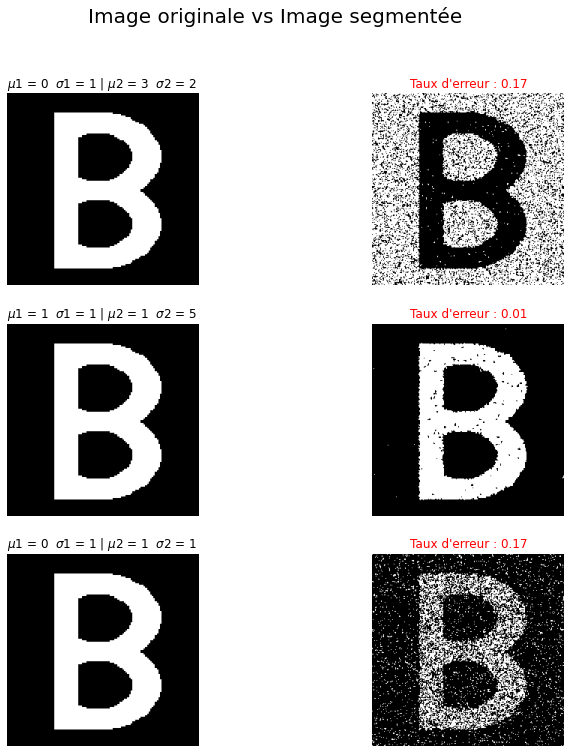

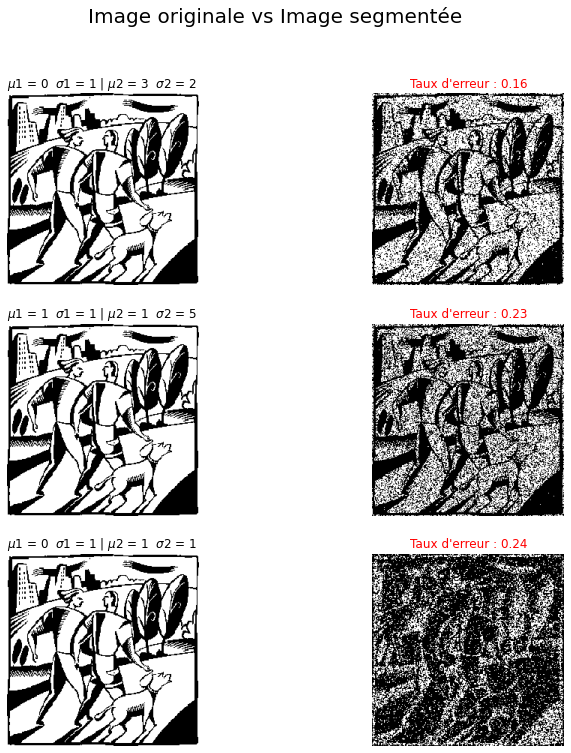

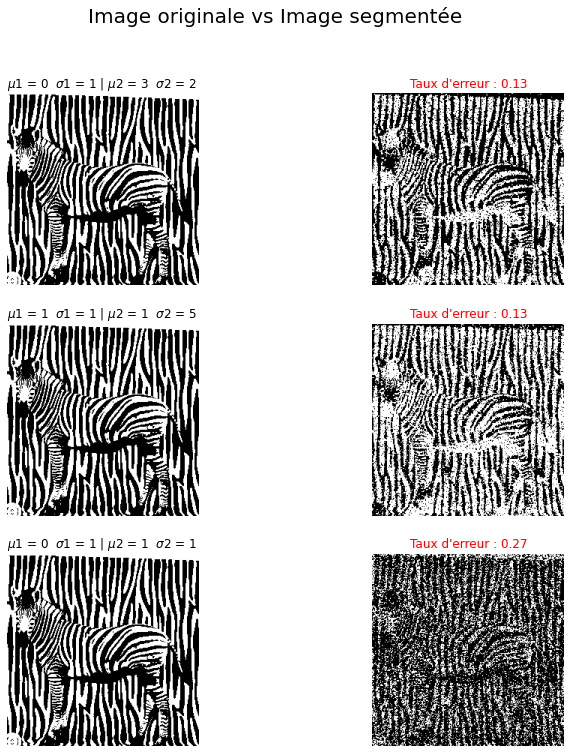

In [66]:
ERREURS_MC = run_mc_all()

## Synthèse:

In [67]:
pd.DataFrame({'bee2': ERREURS_MC[0],
              'promenade2': ERREURS_MC[1],
              'zebre2': ERREURS_MC[2]},
              index=['bruit_1', 'bruit_2', 'bruit_3'])

,bee2,promenade2,zebre2
bruit_1,0.166321,0.159332,0.127502
bruit_2,0.013672,0.233948,0.125214
bruit_3,0.171738,0.237061,0.268570



# Conclusion:


In [68]:
pd.DataFrame({'bee2': ERREURS_MAP_MPM[0]+ERREURS_MC[0],
              'promenade2': ERREURS_MAP_MPM[1]+ERREURS_MC[1],
              'zebre2': ERREURS_MAP_MPM[2]+ERREURS_MC[2]},
              index=[['MPM_MAP', 'MPM_MAP', 'MPM_MAP', 'MARKOV_CACHE', 'MARKOV_CACHE', 'MARKOV_CACHE'],
                    ['bruit_1', 'bruit_2', 'bruit_3','bruit_1', 'bruit_2', 'bruit_3']])

bee2  promenade2    zebre2
MPM_MAP      bruit_1  0.104736    0.162430  0.135239
             bruit_2  0.117722    0.197693  0.161026
             bruit_3  0.306961    0.307724  0.308304
MARKOV_CACHE bruit_1  0.166321    0.159332  0.127502
             bruit_2  0.013672    0.233948  0.125214
             bruit_3  0.171738    0.237061  0.268570

* Globalement le taux d'erreur est moins important dans le Modèle de la chaine de Markov que dans le modèle indépendant. Ce qui implique qu'une 
  chaine de Markov est mieux placée pour représenter une image.

* On remarque que pour un même bruit, en utilisant le Modèle indépendant, les taux d'erreurs des différentes images sont assez proches. Ce qui n'est pas le cas 
  n'est pas le cas pour le modèle de la chaine de Markov cachée. Ceci s'explique par le fait que pour le premier modèle, on considère que le motif de l'image ne 
  suit aucune loi (purement aléatoire) et de ce fait toutes les images sont traitées identiquement alors que dans le deuxième on considère que chaque pixel dépend du précédent.

* La deuxième methode (MC) est plus efficace pour la premiere image, car la transition des pixels (noir vers blanc et viceversa) est moins importante et donc un motif plus simple à segmenter


